# ML Models with feature selection using k-means

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style = 'whitegrid', font_scale = 1.3)

In [2]:
sys.path.append('..')
from modules.plotting_metrics import PlotMetric

#### Loading data

In [3]:
# Read the MDS resutls to be used for clustering
import pickle
path_mds_obj = os.path.join('..', 'data', 'trajectory_analysis', 'cMDS_Pisani_402_obj.pyobj')
with open(path_mds_obj, 'rb') as f:
    mds_pisani_402 = pickle.load(f)

In [4]:
# Helper functions, load after having mds_pisani in memory
%run ./helper_functions_S6.ipynb

In [5]:
# Dictionary of docking results
# notebook helper_functions does the trick
scores_dic = get_docking_scores_dict()

### Get the conformations with the best AUC in each dataset (docking scores using Vinardo)

In [6]:
bc_csar, bc_csar_auc = get_best_conformation('CSAR', 'Dk_sc')

print(F'Best conf. in CSAR:', bc_csar, ', AUC:', bc_csar_auc)

Best conf. in CSAR: 2vv9 , AUC: 0.8486425339366516


In [7]:
bc_dud, bc_dud_auc = get_best_conformation('DUD', 'Dk_sc')

print(F'Best conf. in DUD:', bc_dud, ', AUC:', bc_dud_auc)

Best conf. in DUD: 3le6 , AUC: 0.6750040180006429


In [8]:
bc_dekois, bc_dekois_auc = get_best_conformation('DEKOIS', 'Dk_sc')

print(F'Best conf. in DEKOIS:', bc_dekois, ', AUC:', bc_dekois_auc)

Best conf. in DEKOIS: 2iw6 , AUC: 0.7904375


#### Initialization of some varaibles

In [9]:
N_REPS = 30 # Number of replicas to use in random picking
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1
# Output directory to save the results of each assay
output_dir = '../data/ml_evaluations/'

# Database to be used for training
train_key = 'CSAR'
# Dictionary of scores to be evaluated
scores_dic
# List of type of scores (docking score or ligand efficiency score)
score_types = ['Dk_lef', 'Dk_sc']
# List of datasets to be used as test
test_keys = ['DUD', 'DEKOIS']

### Get the medoids with k-means for k in range 1 to 402

- `random_state = 0` is used in order to get the same k conformations to evaluate all the machine learning models.

#### Using Pisani subspace

In [10]:
%%time
# Precomputed clustering with k-means for k in range 1 to 402
# Save to a file to avoid recompute it each time
file_list_of_confs_per_k =  F'{output_dir}/\
list_of_confs_per_k_pisani_mds.json'

if os.path.isfile(file_list_of_confs_per_k):
    df_confs_per_k = pd.read_json(file_list_of_confs_per_k)
else:
    list_of_confs_per_k = []
    _X = mds_pisani_402[0]

    for n_clusters in range(1, 402 + 1):
        confs_idx = get_medoids_idx(_X, n_clusters = n_clusters, random_state = 0)
        list_of_confs_per_k.append(confs_idx)
        df_confs_per_k = pd.DataFrame({'list_of_confs_pisani': list_of_confs_per_k})
        df_confs_per_k.to_json(file_list_of_confs_per_k)

df_confs_per_k.sort_index(inplace=True)

CPU times: user 6.83 ms, sys: 11.7 ms, total: 18.5 ms
Wall time: 18.1 ms


### Correalted Features
Set of proteins remained after dropping of highly correlated features.

In [11]:
# Get the number of features
file_list_of_confs_per_k_correlated =  F'../data/ml_evaluations/list_of_confs_per_k_drop_correlated_features.json'
df_confs_per_k_CORRELATED = pd.read_json(file_list_of_confs_per_k_correlated)
df_confs_per_k_CORRELATED.sort_index(inplace=True)

In [12]:
# df_confs_per_k_CORRELATED

## Linear SVM
<div style='background-color: #F9E5AB; min-height: 10px'></div>

In [13]:
from sklearn.svm import SVC

#### Random picking

In [14]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys, 
                  n_reps = 30, score_type = score_type,
                  **hyparms)

CPU times: user 4.29 ms, sys: 0 ns, total: 4.29 ms
Wall time: 3.28 ms


#### K-means picking

In [15]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  score_type = score_type,
                  **hyparms)

CPU times: user 2.38 ms, sys: 555 µs, total: 2.94 ms
Wall time: 1.91 ms


#### Correlated Features

In [16]:
%%time
train_key = 'CSAR'
ml_model = SVC
model_name = 'LinearSVC'
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)
df_confs_per_k = df_confs_per_k_CORRELATED

for score_type in score_types:
    lSVC_corr_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  score_type = score_type,
                  method = 'correlated',
                  **hyparms)

CPU times: user 1.15 ms, sys: 3.32 ms, total: 4.47 ms
Wall time: 3.34 ms


#### Recursive Feature Elimination

In [17]:
%%time
train_key = 'CSAR'
ml_model = SVC
model_name = 'LinearSVC'
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)
out_dir = '../data/ml_evaluations/ml_models'

for score_type in score_types:
    # Read the list of conformations rpeviously computed
    df_confs_per_k = pd.read_json(F'{out_dir}/{train_key}_{model_name}_' + \
             F'RFE_{score_type.replace("_","")}.json').sort_index()
    
    lSVC_rfe_dict = kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                      df_precomputed_medoids = df_confs_per_k,
                      score_type = score_type,
                      method = 'rfe',
                      **hyparms)
    print(score_type)

Dk_lef
Dk_sc
CPU times: user 25.8 ms, sys: 7.49 ms, total: 33.3 ms
Wall time: 30.5 ms


<h4>Visualization: <span class="text-muted">Linear SVM Results</span></h4>

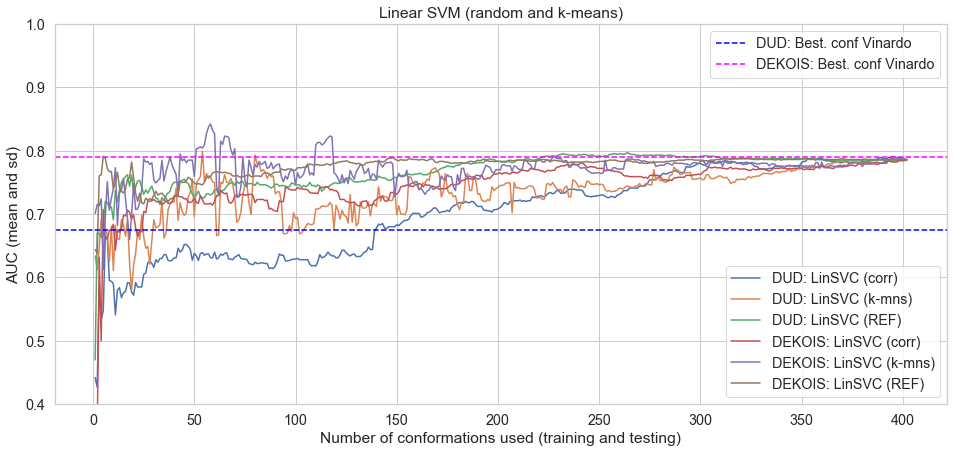

In [18]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'LinSVC (corr)': lSVC_corr_dict, 
                'LinSVC (k-mns)': lSVC_km_dict,
                'LinSVC (REF)': lSVC_rfe_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Linear SVM (random and k-means)')
plt.show()

## Radial Basis Function SVM
<div style='background-color: #F9E5AB; min-height: 10px'></div>

#### Random picking

In [19]:
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

for score_type in score_types:
    rbfSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, 
                            test_keys, n_reps = 30, score_type = score_type, interval = 2,
                  **hyparms)

#### K-means picking

In [20]:
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

for score_type in score_types:
    rbfSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k, score_type = score_type,
                  **hyparms)

#### Correlated Features

In [21]:
train_key = 'CSAR'
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)
df_confs_per_k = df_confs_per_k_CORRELATED

for score_type in score_types:
    rbfSVC_corr_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k, score_type = score_type,
                  method = 'correlated',
                  **hyparms)

#### Recursive Feature Elimination

In [22]:
%%time
train_key = 'CSAR'
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)
out_dir = '../data/ml_evaluations/ml_models'
file_sufix = '_RFE-LgRgL2'
model_name_rfe = 'LogRg'

for score_type in score_types:
    # Read the list of conformations rpeviously computed
    df_confs_per_k = pd.read_json(F'{out_dir}/{train_key}_{model_name_rfe}_' + \
             F'RFE_{score_type.replace("_","")}.json').sort_index()
    
    rbfSVC_rfe_dict = kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                      df_precomputed_medoids = df_confs_per_k,
                      score_type = score_type,
                      method = 'rfe', file_sufix = file_sufix,
                      **hyparms)
    print(score_type)

Dk_lef
Dk_sc
CPU times: user 30.5 ms, sys: 4.58 ms, total: 35.1 ms
Wall time: 33.7 ms


In [23]:
# %%time
# ml_model = SVC
# model_name = 'rbfSVC'
# # hyperparameters
# hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

# # Hyperparameters for RFE
# from sklearn.linear_model import LogisticRegression
# rfe_model = LogisticRegression
# rfe_model_hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')
# file_sufix = '_RFE-LgRgL2_'

# for score_type in score_types:
#     rbfSVC_rfe_dict =  RFE_wrapper(ml_model, model_name, scores_dic, train_key, test_keys,
#                              score_type = score_type, interval = 2,
#                              # extra parameters for RFE
#                              min_confs= 2, # Minimum required for REF
#                              train_by_itself = False, model_for_RFE = rfe_model,
#                              file_sufix = file_sufix, rfe_model_hyparms = rfe_model_hyparms,
#                             # Main estimator hyperparameters
#                              **hyparms)

<h4>Visualization: <span class="text-muted">Radial Basis Function SVM</span></h4>

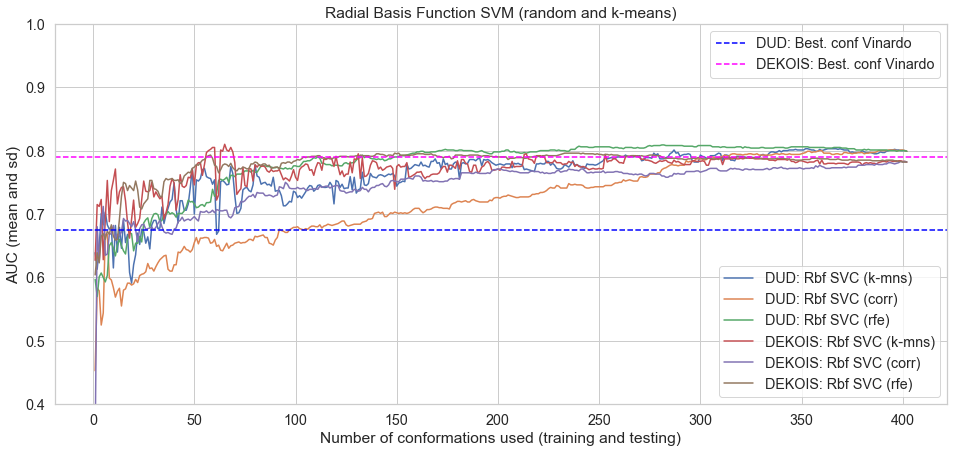

In [24]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {#'Rbf SVC (rand)': rbfSVC_rd_dict, 
            'Rbf SVC (k-mns)': rbfSVC_km_dict,
            'Rbf SVC (corr)': rbfSVC_corr_dict,
            'Rbf SVC (rfe)': rbfSVC_rfe_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Radial Basis Function SVM (random and k-means)')
plt.show()

## Logistic Regression
<div style='background-color: #F9E5AB; min-height: 10px'></div>

In [25]:
from sklearn.linear_model import LogisticRegression

#### Random picking

In [26]:
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, 
                                  train_key, test_keys, n_reps = 30, 
                                      score_type = score_type, interval = 2,
                                  **hyparms)

#### K-means picking

In [27]:
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                                   score_type = score_type,
                  **hyparms)

#### Correlated Features

In [28]:
%%time
train_key = 'CSAR'
df_confs_per_k = df_confs_per_k_CORRELATED
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_corr_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  score_type = score_type,
                  method = 'correlated',
                  **hyparms)

CPU times: user 3.41 ms, sys: 0 ns, total: 3.41 ms
Wall time: 2.23 ms


#### Recursive Feature Elimination

In [29]:
%%time
train_key = 'CSAR'
ml_model = LogisticRegression
model_name = 'LogRg'
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs', max_iter = 200)
out_dir = '../data/ml_evaluations/ml_models'

for score_type in score_types:
    # Read the list of conformations rpeviously computed
    df_confs_per_k = pd.read_json(F'{out_dir}/{train_key}_{model_name}_' + \
             F'RFE_{score_type.replace("_","")}.json').sort_index()
    
    logRG_rfe_dict = kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                      df_precomputed_medoids = df_confs_per_k,
                      score_type = score_type,
                      method = 'rfe',
                      **hyparms)
    print(score_type)

Dk_lef
Dk_sc
CPU times: user 20.2 ms, sys: 11.1 ms, total: 31.4 ms
Wall time: 28.8 ms


In [30]:
# %%time
# ml_model = LogisticRegression
# model_name = 'LogRg'
# # hyperparameters
# hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

# for score_type in score_types:
#     logRG_rfe_dict =  RFE_wrapper(ml_model, model_name, scores_dic, train_key, test_keys,
#                               score_type = score_type, interval = 2,
#                             **hyparms)

<h4>Visualization: <span class="text-muted">Logistic Regression</span></h4>

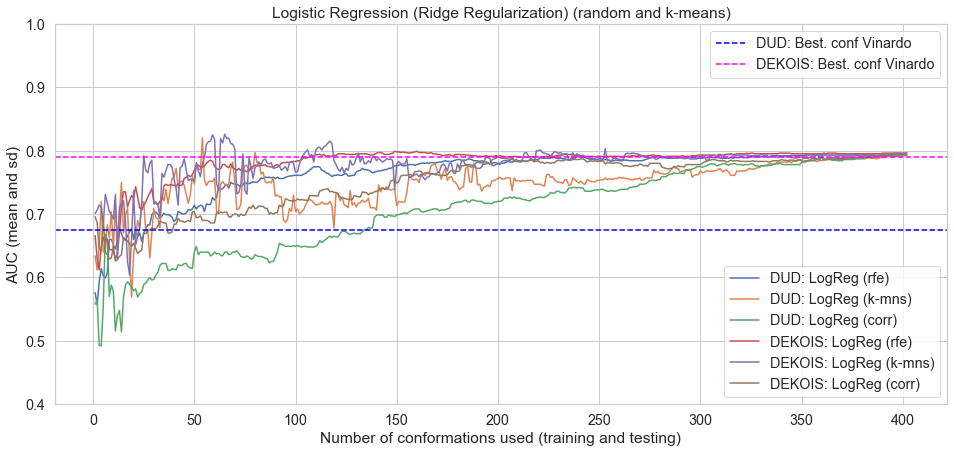

In [31]:
# Results
sns.set(context='notebook', style = 'whitegrid', font_scale = 1.3)
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'LogReg (rfe)': logRG_rfe_dict,
                'LogReg (k-mns)': logRG_km_dict,
                'LogReg (corr)': logRG_corr_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax)
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Logistic Regression (Ridge Regularization) (random and k-means)')
plt.show()

## Decision Tree Classifier
<div style='background-color: #F9E5AB; min-height: 10px'></div>

In [32]:
from sklearn.tree import DecisionTreeClassifier

#### Random Picking

In [33]:
%%time
ml_model = DecisionTreeClassifier
model_name = 'Tree'
# hyperparameters
hyparms = dict(criterion = 'gini', max_depth = 2)

dTree_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, 
                                  train_key, test_keys, n_reps = 30,
                                  **hyparms)

CPU times: user 2.24 ms, sys: 0 ns, total: 2.24 ms
Wall time: 2.17 ms


#### K-means Picking

In [34]:
#%%time
ml_model = DecisionTreeClassifier
model_name = 'Tree'
# hyperparameters
hyparms = dict(criterion = 'gini', max_depth = 2)

dTree_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

#### Recursive Feature Elimination

In [35]:
%%time
train_key = 'CSAR'
ml_model = DecisionTreeClassifier
model_name = 'Tree'
hyparms = dict(criterion = 'gini', max_depth = 2)
out_dir = '../data/ml_evaluations/ml_models'

for score_type in score_types:
    # Read the list of conformations rpeviously computed
    df_confs_per_k = pd.read_json(F'{out_dir}/{train_key}_{model_name}_' + \
             F'RFE_{score_type.replace("_","")}.json').sort_index()
    
    mdl_rfe_dict = kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                      df_precomputed_medoids = df_confs_per_k,
                      score_type = score_type,
                      method = 'rfe',
                      **hyparms)
    print(score_type)

Dk_lef
Dk_sc
CPU times: user 28.3 ms, sys: 4.08 ms, total: 32.4 ms
Wall time: 31.3 ms


In [36]:
# %%time
# ml_model = DecisionTreeClassifier
# model_name = 'Tree'
# # hyperparameters
# hyparms = dict(criterion = 'gini', max_depth = 2)

# dTree_ref_dict =  RFE_wrapper(ml_model, model_name, scores_dic, train_key, test_keys,
#                             **hyparms)

<h4>Visualization: <span class="text-muted">Decision Tree Classifier</span></h4>

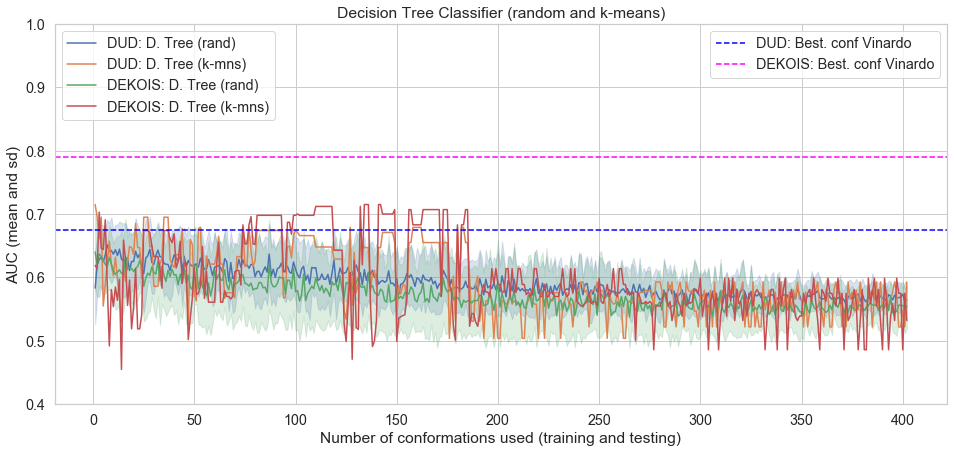

In [37]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'D. Tree (rand)': dTree_rd_dict, 'D. Tree (k-mns)': dTree_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, legend_position = 'upper left')
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Decision Tree Classifier (random and k-means)')
plt.show()

## Dummy Classifier
<div style='background-color: #F9E5AB; min-height: 10px'></div>

In [38]:
from sklearn.dummy import DummyClassifier

#### K-means picking

In [39]:
ml_model = DummyClassifier
model_name = 'DummyStf'
# hyperparameters
hyparms = dict(strategy = 'stratified')

DummyStf_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  **hyparms)

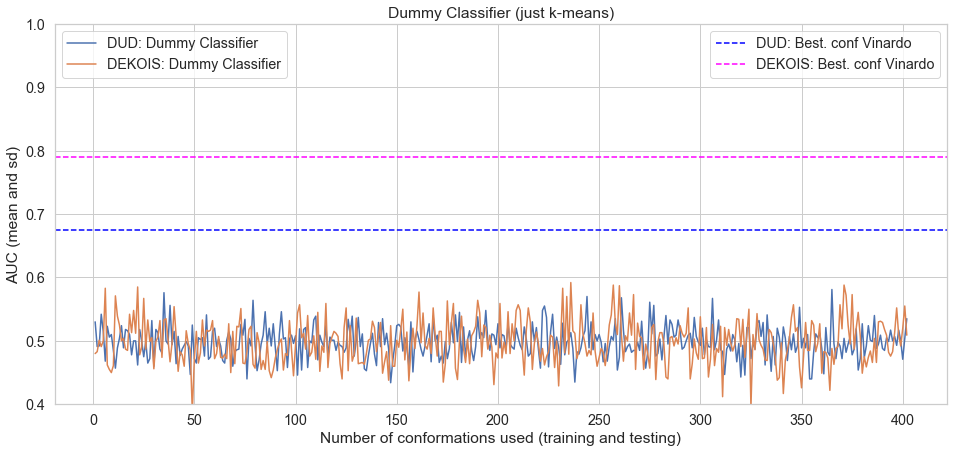

In [40]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'Dummy Classifier': DummyStf_km_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, legend_position = 'upper left')
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Dummy Classifier (just k-means)')
plt.show()

# DEKOIS TRAINING

In [41]:
N_REPS = 30 # Number of replicas to use in random picking
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1
# Output directory to save the results of each assay
output_dir = '../data/ml_evaluations/'

# Database to be used for training
train_key = 'DEKOIS'
# Dictionary of scores to be evaluated
scores_dic
# List of type of scores (docking score or ligand efficiency score)
score_types = ['Dk_lef', 'Dk_sc']
# List of datasets to be used as test
test_keys = ['DUD', 'CSAR']

### Linear SVM

In [42]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys, 
                  n_reps = 30, score_type = score_type,
                                     interval = 2,
                  **hyparms)

CPU times: user 1.07 ms, sys: 4.21 ms, total: 5.28 ms
Wall time: 4.02 ms


In [43]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    lSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  score_type = score_type, 
                  **hyparms)

CPU times: user 2.2 ms, sys: 428 µs, total: 2.63 ms
Wall time: 1.59 ms


In [44]:
%%time
train_key = 'DEKOIS'
ml_model = SVC
model_name = 'LinearSVC'
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)
df_confs_per_k = df_confs_per_k_CORRELATED

for score_type in score_types:
    lSVC_corr_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  score_type = score_type,
                  method = 'correlated',
                  **hyparms)

CPU times: user 335 µs, sys: 4.06 ms, total: 4.4 ms
Wall time: 3.44 ms


In [45]:
%%time
train_key = 'DEKOIS'
ml_model = SVC
model_name = 'LinearSVC'
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)
out_dir = '../data/ml_evaluations/ml_models'

for score_type in score_types:
    # Read the list of conformations rpeviously computed
    df_confs_per_k = pd.read_json(F'{out_dir}/{train_key}_{model_name}_' + \
             F'RFE_{score_type.replace("_","")}.json').sort_index()
    
    lSVC_rfe_dict = kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                      df_precomputed_medoids = df_confs_per_k,
                      score_type = score_type,
                      method = 'rfe',
                      **hyparms)
    print(score_type)

Dk_lef
Dk_sc
CPU times: user 26.4 ms, sys: 9.93 ms, total: 36.3 ms
Wall time: 34.6 ms


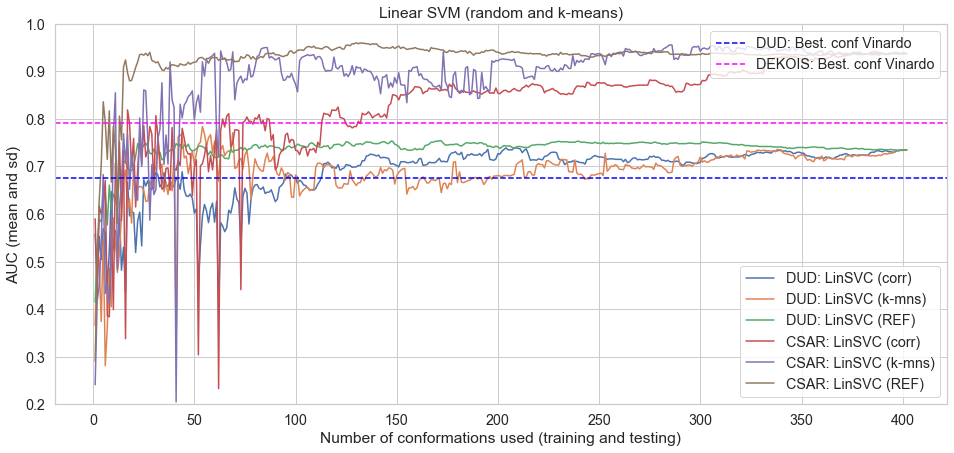

In [46]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'LinSVC (corr)': lSVC_corr_dict, 
                'LinSVC (k-mns)': lSVC_km_dict,
                'LinSVC (REF)': lSVC_rfe_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, y_lim = (0.2, 1))
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Linear SVM (random and k-means)')
plt.show()

### Radial Baisis Function SVM

In [47]:
%%time
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

for score_type in score_types:
    print(score_type)
    rbfSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, 
                                       test_keys, n_reps = 30, score_type = score_type,
                                       interval = 2,
                  **hyparms)

Dk_lef
Dk_sc
CPU times: user 4.26 ms, sys: 8.06 ms, total: 12.3 ms
Wall time: 7.04 ms


In [48]:
%%time
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

for score_type in score_types:
    print(score_type)
    rbfSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k, score_type = score_type, 
                  **hyparms)

Dk_lef
Dk_sc
CPU times: user 2.53 ms, sys: 3.72 ms, total: 6.25 ms
Wall time: 3.18 ms


In [49]:
train_key = 'DEKOIS'
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)
df_confs_per_k = df_confs_per_k_CORRELATED

for score_type in score_types:
    rbfSVC_corr_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k, score_type = score_type,
                  method = 'correlated',
                  **hyparms)

In [50]:
%%time
train_key = 'DEKOIS'
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)
out_dir = '../data/ml_evaluations/ml_models'
file_sufix = '_RFE-LgRgL2'
model_name_rfe = 'LogRg'

for score_type in score_types:
    # Read the list of conformations rpeviously computed
    df_confs_per_k = pd.read_json(F'{out_dir}/{train_key}_{model_name_rfe}_' + \
             F'RFE_{score_type.replace("_","")}.json').sort_index()
    
    rbfSVC_rfe_dict = kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                      df_precomputed_medoids = df_confs_per_k,
                      score_type = score_type,
                      method = 'rfe', file_sufix = file_sufix,
                      **hyparms)
    print(score_type)

Dk_lef
Dk_sc
CPU times: user 30.2 ms, sys: 4.43 ms, total: 34.7 ms
Wall time: 32.2 ms


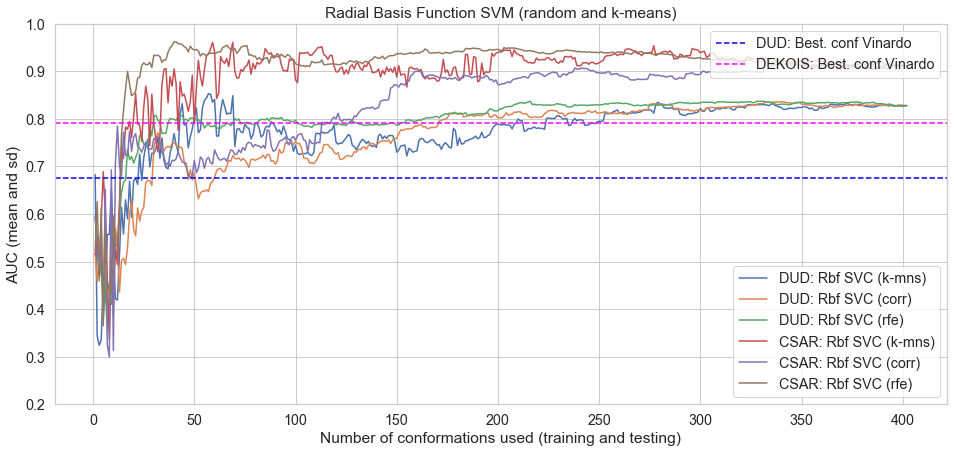

In [51]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {#'Rbf SVC (rand)': rbfSVC_rd_dict, 
            'Rbf SVC (k-mns)': rbfSVC_km_dict,
            'Rbf SVC (corr)': rbfSVC_corr_dict,
            'Rbf SVC (rfe)': rbfSVC_rfe_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, y_lim = (0.2, 1))
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Radial Basis Function SVM (random and k-means)')
plt.show()

### Logistic Regression

In [52]:
%%time
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs', n_jobs = 4, max_iter = 200)

for score_type in score_types:
    print(score_type)
    logRG_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, 
                                  train_key, test_keys, n_reps = 30, interval = 2,
                                      score_type = score_type,
                                  **hyparms)

Dk_lef
Dk_sc
CPU times: user 3.21 ms, sys: 4.61 ms, total: 7.82 ms
Wall time: 4.55 ms


In [53]:
%%time
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs', n_jobs = 4, max_iter = 200)

for score_type in score_types:
    print(score_type)
    logRG_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                                   score_type = score_type, 
                  **hyparms)

Dk_lef
Dk_sc
CPU times: user 4.11 ms, sys: 772 µs, total: 4.89 ms
Wall time: 2.62 ms


In [54]:
%%time
train_key = 'DEKOIS'
df_confs_per_k = df_confs_per_k_CORRELATED
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs', max_iter = 200)

for score_type in score_types:
    logRG_corr_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  score_type = score_type,
                  method = 'correlated',
                  **hyparms)

CPU times: user 1min 48s, sys: 1min 20s, total: 3min 9s
Wall time: 47.5 s


In [55]:
%%time
train_key = 'DEKOIS'
ml_model = LogisticRegression
model_name = 'LogRg'
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs', max_iter = 200)
out_dir = '../data/ml_evaluations/ml_models'

for score_type in score_types:
    # Read the list of conformations rpeviously computed
    df_confs_per_k = pd.read_json(F'{out_dir}/{train_key}_{model_name}_' + \
             F'RFE_{score_type.replace("_","")}.json').sort_index()
    
    logRG_rfe_dict = kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                      df_precomputed_medoids = df_confs_per_k,
                      score_type = score_type,
                      method = 'rfe',
                      **hyparms)
    print(score_type)

Dk_lef
Dk_sc
CPU times: user 3min 42s, sys: 2min 43s, total: 6min 25s
Wall time: 1min 36s


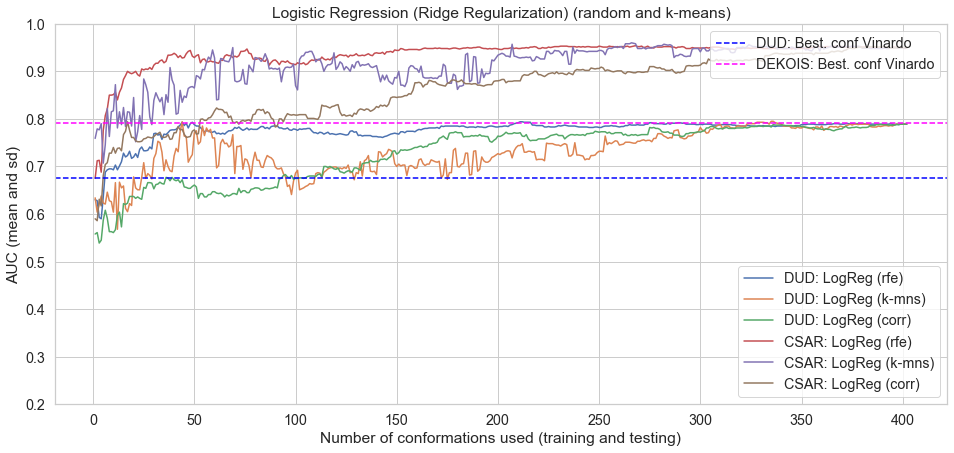

In [56]:
# Results
sns.set(context='notebook', style = 'whitegrid', font_scale = 1.3)
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'LogReg (rfe)': logRG_rfe_dict,
                'LogReg (k-mns)': logRG_km_dict,
                'LogReg (corr)': logRG_corr_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, y_lim = (0.2, 1))
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Logistic Regression (Ridge Regularization) (random and k-means)')
plt.show()

# DUD TRAINING

In [57]:
N_REPS = 30 # Number of replicas to use in random picking
MIN_CONFS = 1
MAX_CONFS = 402
INTERVAL = 1
# Output directory to save the results of each assay
output_dir = '../data/ml_evaluations/'

# Database to be used for training
train_key = 'DUD'
# Dictionary of scores to be evaluated
scores_dic
# List of type of scores (docking score or ligand efficiency score)
score_types = ['Dk_lef', 'Dk_sc']
# List of datasets to be used as test
test_keys = ['DEKOIS', 'CSAR']

In [58]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    print(score_type)
    lSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys, 
                  n_reps = 30, score_type = score_type,
                                     interval = 2,
                  **hyparms)

Dk_lef
Dk_sc
CPU times: user 5.59 ms, sys: 1.14 ms, total: 6.73 ms
Wall time: 4.82 ms


In [59]:
%%time
ml_model = SVC
model_name = 'LinearSVC'
# hyperparameters
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)

for score_type in score_types:
    print(score_type)
    lSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  score_type = score_type, 
                  **hyparms)

Dk_lef
Dk_sc
CPU times: user 4.18 ms, sys: 123 µs, total: 4.31 ms
Wall time: 2.65 ms


In [60]:
train_key = 'DUD'
ml_model = SVC
model_name = 'LinearSVC'
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)
df_confs_per_k = df_confs_per_k_CORRELATED

for score_type in score_types:
    lSVC_corr_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  score_type = score_type,
                  method = 'correlated',
                  **hyparms)

In [61]:
%%time
train_key = 'DUD'
ml_model = SVC
model_name = 'LinearSVC'
hyparms = dict(kernel = 'linear', probability = True, C = 0.1)
out_dir = '../data/ml_evaluations/ml_models'

for score_type in score_types:
    # Read the list of conformations rpeviously computed
    df_confs_per_k = pd.read_json(F'{out_dir}/{train_key}_{model_name}_' + \
             F'RFE_{score_type.replace("_","")}.json').sort_index()
    
    lSVC_rfe_dict = kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                      df_precomputed_medoids = df_confs_per_k,
                      score_type = score_type,
                      method = 'rfe',
                      **hyparms)
    print(score_type)

Dk_lef
Dk_sc
CPU times: user 11min 57s, sys: 19.7 s, total: 12min 17s
Wall time: 12min 17s


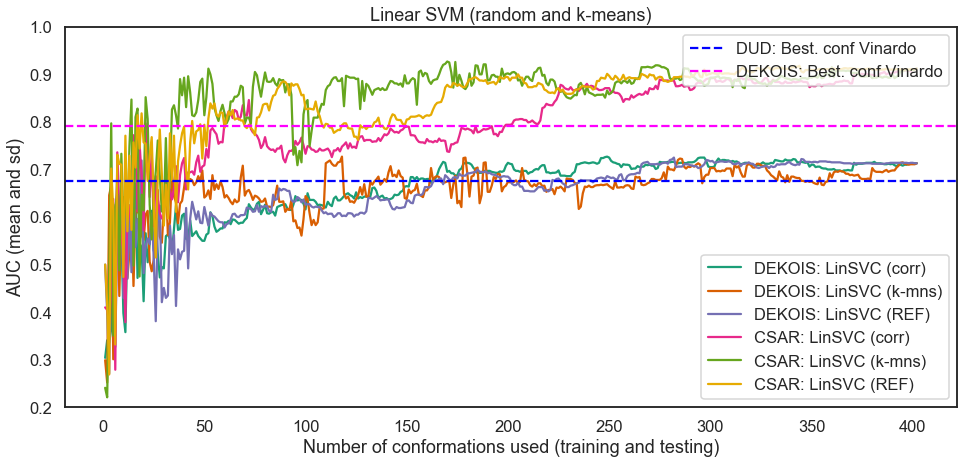

In [62]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'LinSVC (corr)': lSVC_corr_dict, 
                'LinSVC (k-mns)': lSVC_km_dict,
                'LinSVC (REF)': lSVC_rfe_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, y_lim = (0.2, 1))
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Linear SVM (random and k-means)')
plt.show()

In [63]:
%%time
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

for score_type in score_types:
    print(score_type)
    rbfSVC_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, train_key, 
                                       test_keys, n_reps = 30, score_type = score_type,
                                       interval = 2,
                  **hyparms)

Dk_lef
Dk_sc
CPU times: user 9.28 ms, sys: 4.2 ms, total: 13.5 ms
Wall time: 8.29 ms


In [64]:
%%time
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)

for score_type in score_types:
    print(score_type)
    rbfSVC_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k, score_type = score_type,
                  **hyparms)

Dk_lef
Dk_sc
CPU times: user 958 µs, sys: 4.15 ms, total: 5.11 ms
Wall time: 3.2 ms


In [65]:
train_key = 'DUD'
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)
df_confs_per_k = df_confs_per_k_CORRELATED

for score_type in score_types:
    rbfSVC_corr_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k, score_type = score_type,
                  method = 'correlated',
                  **hyparms)

In [66]:
%%time
train_key = 'DUD'
ml_model = SVC
model_name = 'rbfSVC'
# hyperparameters
hyparms = dict(kernel = 'rbf', probability = True, gamma = 0.001, C = 10)
out_dir = '../data/ml_evaluations/ml_models'
file_sufix = '_RFE-LgRgL2'
model_name_rfe = 'LogRg'

for score_type in score_types:
    # Read the list of conformations rpeviously computed
    df_confs_per_k = pd.read_json(F'{out_dir}/{train_key}_{model_name_rfe}_' + \
             F'RFE_{score_type.replace("_","")}.json').sort_index()
    
    rbfSVC_rfe_dict = kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                      df_precomputed_medoids = df_confs_per_k,
                      score_type = score_type,
                      method = 'rfe', file_sufix = file_sufix,
                      **hyparms)
    print(score_type)

Dk_lef
Dk_sc
CPU times: user 14min 43s, sys: 3.1 s, total: 14min 46s
Wall time: 14min 46s


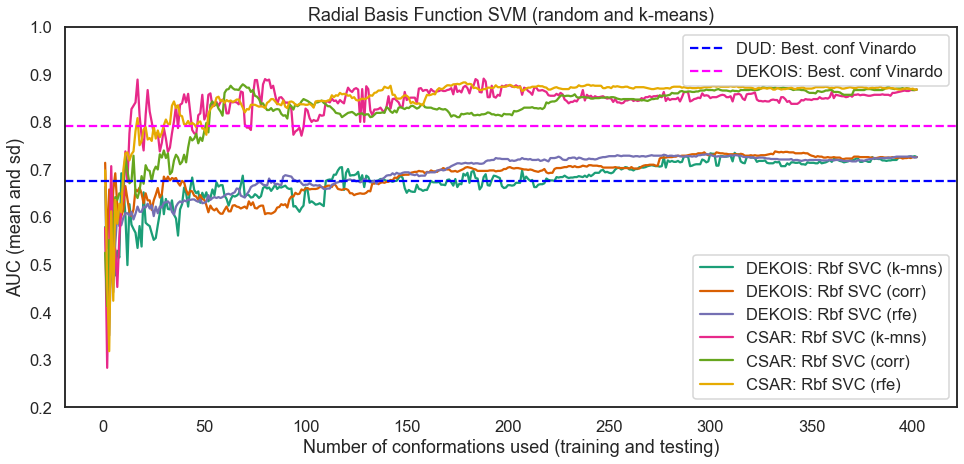

In [67]:
# Results
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {#'Rbf SVC (rand)': rbfSVC_rd_dict, 
            'Rbf SVC (k-mns)': rbfSVC_km_dict,
            'Rbf SVC (corr)': rbfSVC_corr_dict,
            'Rbf SVC (rfe)': rbfSVC_rfe_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, y_lim = (0.2, 1))
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Radial Basis Function SVM (random and k-means)')
plt.show()

In [68]:
%%time
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs', n_jobs = 4, max_iter = 200)

for score_type in score_types:
    print(score_type)
    logRG_rd_dict = random_picking_ML(ml_model, model_name, scores_dic, 
                                  train_key, test_keys, n_reps = 30, interval = 2,
                                      score_type = score_type,
                                  **hyparms)

Dk_lef
Dk_sc
CPU times: user 2.54 ms, sys: 3.88 ms, total: 6.42 ms
Wall time: 3.55 ms


In [69]:
%%time
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs', n_jobs = 4, max_iter = 200)

for score_type in score_types:
    print(score_type)
    logRG_km_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                                   score_type = score_type, 
                  **hyparms)

Dk_lef
Dk_sc
CPU times: user 0 ns, sys: 7.75 ms, total: 7.75 ms
Wall time: 5.25 ms


In [70]:
%%time
train_key = 'DUD'
df_confs_per_k = df_confs_per_k_CORRELATED
ml_model = LogisticRegression
model_name = 'LogRg'
# hyperparameters
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs')

for score_type in score_types:
    logRG_corr_dict =  kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                  df_precomputed_medoids = df_confs_per_k,
                  score_type = score_type,
                  method = 'correlated',
                  **hyparms)

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

CPU times: user 6min 1s, sys: 3min 45s, total: 9min 46s
Wall time: 2min 27s


/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [71]:
%%time
train_key = 'DUD'
ml_model = LogisticRegression
model_name = 'LogRg'
hyparms = dict(C = 1, penalty = 'l2', solver = 'lbfgs', max_iter = 200)
out_dir = '../data/ml_evaluations/ml_models'

for score_type in score_types:
    # Read the list of conformations rpeviously computed
    df_confs_per_k = pd.read_json(F'{out_dir}/{train_key}_{model_name}_' + \
             F'RFE_{score_type.replace("_","")}.json').sort_index()
    
    logRG_rfe_dict = kmeans_picking_ML(ml_model, model_name, scores_dic, train_key, test_keys,
                      df_precomputed_medoids = df_confs_per_k,
                      score_type = score_type,
                      method = 'rfe',
                      **hyparms)
    print(score_type)

Dk_lef
Dk_sc
CPU times: user 6min, sys: 3min 35s, total: 9min 36s
Wall time: 2min 24s


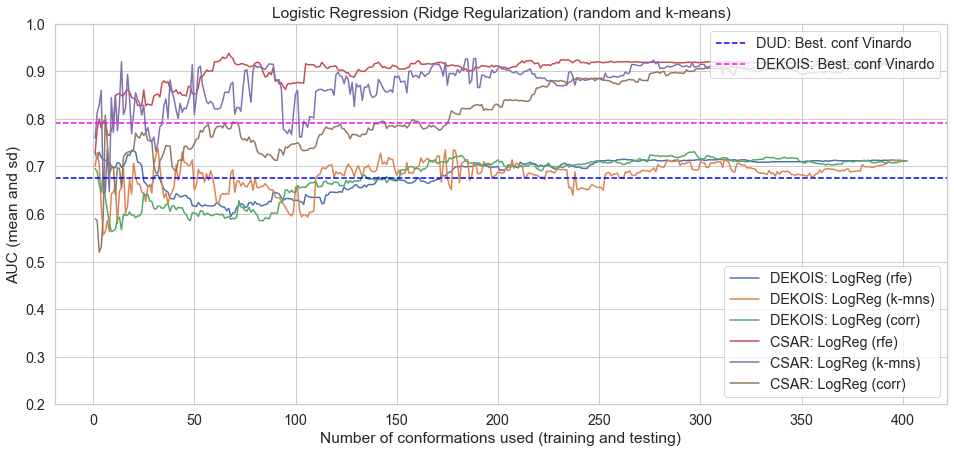

In [72]:
# Results
sns.set(context='notebook', style = 'whitegrid', font_scale = 1.3)
fig, ax = plt.subplots(figsize=(16, 7))
_results_dic = {'LogReg (rfe)': logRG_rfe_dict,
                'LogReg (k-mns)': logRG_km_dict,
                'LogReg (corr)': logRG_corr_dict}

_plot_results(results_dic = _results_dic, test_keys = test_keys, ax = ax, y_lim = (0.2, 1))
ax.set_xlabel('Number of conformations used (training and testing)')
ax.set_ylabel('AUC (mean and sd)')
ax.set_title('Logistic Regression (Ridge Regularization) (random and k-means)')
plt.show()